In [3]:
import json 
import pandas as pd
from tqdm import tqdm
import numpy as np
import os
import matplotlib.pyplot as plt

files = os.listdir('../Data/Analysed')

datas = []
players = {}
all_obs = [] 
games = []
# playername, rating, difference, time 
for file in tqdm(files):
    with open('../Data/Analysed/' + file) as f:
        data = json.load(f)
    
    white_moves_time, black_moves_time = data["game"]["moveTimestamps"].split(",")[:-1][::2], data["game"]["moveTimestamps"].split(",")[:-1][1::2]
    white_moves_time, black_moves_time = [int(x)/10 for x in white_moves_time], [int(x)/10 for x in black_moves_time]
    time_diffs_white, time_diffs_black = [0] + list(np.diff(white_moves_time)), [0] + list(np.diff(black_moves_time))
    
    user_black = data["players"]["top"]["username"]
    user_white = data["players"]["bottom"]["username"]
    rating_black = data["players"]["top"]["rating"]
    rating_white = data["players"]["bottom"]["rating"]

    white_loss = [x["difference"] for x in data["evaluations"] if x["player"] == "white"]
    black_loss = [x["difference"] for x in data["evaluations"] if x["player"] == "black"]
    white_loss_after_10 = np.median(white_loss[10:])
    black_loss_after_10 = np.median(black_loss[10:])
    white_loss = np.median(white_loss)
    black_loss = np.median(black_loss)
    white_perc_best_move = np.mean([x["Ranking Real Move"] == 1 for x in data["evaluations"] if x["player"] == "white"])
    black_perc_best_move = np.mean([x["Ranking Real Move"] == 1 for x in data["evaluations"] if x["player"] == "black"])
    white_perc_very_good_move = np.mean([x["Ranking Real Move"] <= 3 for x in data["evaluations"] if x["player"] == "white"])
    black_perc_very_good_move = np.mean([x["Ranking Real Move"] <= 3 for x in data["evaluations"] if x["player"] == "black"])

    white_perc_best_move_after_10 = np.mean([x["Ranking Real Move"] == 1 for x in data["evaluations"][10:] if x["player"] == "white"])
    black_perc_best_move_after_10 = np.mean([x["Ranking Real Move"] == 1 for x in data["evaluations"][10:] if x["player"] == "black"])
    # Ranking Real Move (if -1 => 10)
    avg_rank_white = np.mean([x["Ranking Real Move"] if x["Ranking Real Move"] > 0 else 10 for x in data["evaluations"] if x["player"] == "white"])
    avg_rank_black = np.mean([x["Ranking Real Move"] if x["Ranking Real Move"] > 0 else 10 for x in data["evaluations"] if x["player"] == "black"])
    ranks_white = [x["Ranking Real Move"] if x["Ranking Real Move"] > 0 else 10 for x in data["evaluations"] if x["player"] == "white"]
    ranks_black = [x["Ranking Real Move"] if x["Ranking Real Move"] > 0 else 10 for x in data["evaluations"] if x["player"] == "black"]

    if user_black not in players:
        players[user_black] = {"games": 0, "loss": [], "loss_after_10": [], "perc_best_move": [], "perc_best_move_after_10": [], "rating": [], "avg_rank": [], "ranks": [], "very_good_move": []}
    if user_white not in players:
        players[user_white] = {"games": 0, "loss": [], "loss_after_10": [], "perc_best_move": [], "perc_best_move_after_10": [], "rating": [], "avg_rank": [], "ranks": [], "very_good_move": []}
    
    players[user_black]["games"] += 1
    players[user_white]["games"] += 1
    players[user_black]["loss"].append(black_loss)
    players[user_white]["loss"].append(white_loss)
    players[user_black]["loss_after_10"].append(black_loss_after_10)
    players[user_white]["loss_after_10"].append(white_loss_after_10)
    players[user_black]["perc_best_move"].append(black_perc_best_move)
    players[user_white]["perc_best_move"].append(white_perc_best_move)
    players[user_black]["perc_best_move_after_10"].append(black_perc_best_move_after_10)
    players[user_white]["perc_best_move_after_10"].append(white_perc_best_move_after_10)
    players[user_black]["rating"].append(rating_black)
    players[user_white]["rating"].append(rating_white)
    players[user_black]["avg_rank"].append(avg_rank_black)
    players[user_white]["avg_rank"].append(avg_rank_white)
    players[user_black]["ranks"].append(ranks_black)
    players[user_white]["ranks"].append(ranks_white)
    players[user_black]["very_good_move"].append(black_perc_very_good_move)
    players[user_white]["very_good_move"].append(white_perc_very_good_move)

    white_moves, black_moves = 0, 0
    for i in range(len(data["evaluations"])):
        white_moves += 1 if data["evaluations"][i]["player"] == "white" else 0
        black_moves += 1 if data["evaluations"][i]["player"] == "black" else 0
        all_obs.append({"player": user_black if i % 2 == 0 else user_white, 
                        "colour": 0 if i % 2 == 0 else 1,
                        "rating":  np.mean(players[user_black]["rating"]) if i % 2 == 0 else np.mean(players[user_white]["rating"]),
                        "difference": -np.abs(data["evaluations"][i]["Best Move Eval"] - data["evaluations"][i]["Real Move Eval"]),
                        "time": time_diffs_white[white_moves-1] if data["evaluations"][i]["player"] == "white" else time_diffs_black[black_moves-1],
                        "remaining_time": white_moves_time[white_moves-1] if data["evaluations"][i]["player"] == "white" else black_moves_time[black_moves-1],
                        "Ranking Real Move": data["evaluations"][i]["Ranking Real Move"],
                        "Move_Num" : white_moves if data["evaluations"][i]["player"] == "white" else black_moves,
                        "opponent": user_white if i % 2 == 0 else user_black,
                        "game_id": data["game"]["id"],
                        "oppenent_rating": np.mean(players[user_white]["rating"]) if i % 2 == 0 else np.mean(players[user_black]["rating"]),
                        "real_eval": data["evaluations"][i]["Real Move Eval"],
                        "best_eval": data["evaluations"][i]["Best Move Eval"]})

100%|██████████| 6789/6789 [00:13<00:00, 520.20it/s]


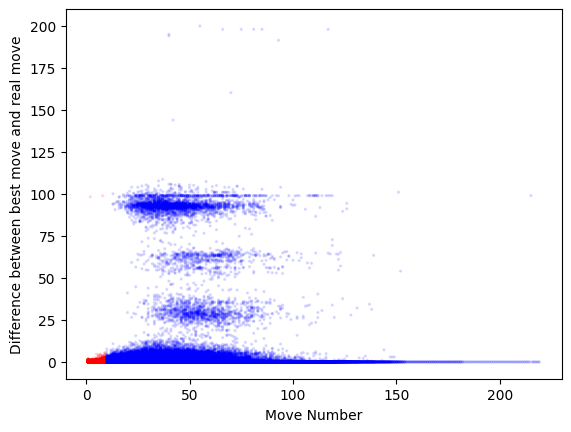

In [4]:
all_obs_df = pd.DataFrame(all_obs)
all_obs_df["difference"] = all_obs_df["difference"] * -1
all_obs_df["blunder"] = all_obs_df["difference"] > 2
all_obs_df["blunder"] = all_obs_df["difference"] > 1
blunds = all_obs_df.groupby("player").agg({"blunder": "mean", "rating": "first", "difference": "size"}).reset_index()
blunds.columns = ["player", "blunder", "rating", "games"]
plt.scatter(all_obs_df["Move_Num"], all_obs_df["difference"], c=all_obs_df["Move_Num"] < 10, cmap="bwr", alpha=0.1, s = 2)
plt.xlabel("Move Number")
plt.ylabel("Difference between best move and real move")
df = pd.DataFrame(players).T

In [5]:
def get_longest_1_count(l):        
    if len(l) < 11:
        return 0
    longest = 0
    current = 0
    for i in l[10:]:
        if i == 1:
            current += 1
        else:
            if current > longest:
                longest = current
            current = 0
    return longest

def get_longest_list_of_lists(x):
    if isinstance(x[0], list):
        return [get_longest_1_count(l) for l in x]
    else:
        return [get_longest_1_count(x)]
        

df["longest_first"] = df.ranks.apply(get_longest_list_of_lists)

In [6]:
# All columns except for "games" - are lists
# calculate the mean of each list
for col in df.columns:
    if col != "games" and col != "ranks":
        df[col] = df[col].apply(lambda x: np.mean(x))

/var/folders/cp/m2q0dkfd3pq8z_955gmxfhv00000gn/T/ipykernel_33000/3597968282.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df.loc[df["games"] > 5,"rating"][i] > 3200:
/var/folders/cp/m2q0dkfd3pq8z_955gmxfhv00000gn/T/ipykernel_33000/3597968282.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df.loc[df["games"] > 5,"loss"][i] > 0.5:
/var/folders/cp/m2q0dkfd3pq8z_955gmxfhv00000gn/T/ipykernel_33000/3597968282.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

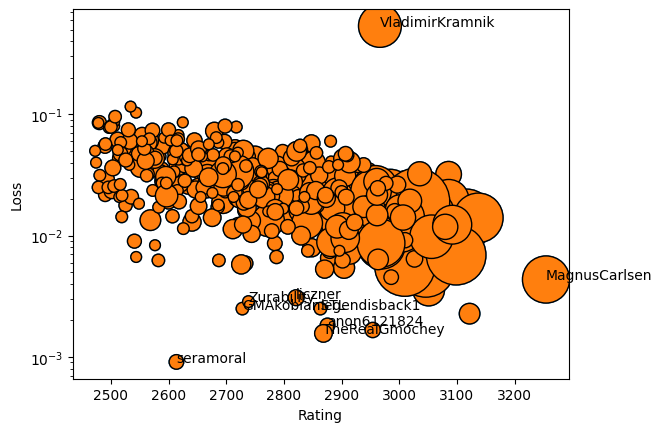

In [7]:
# Plot rating vs loss
import matplotlib.pyplot as plt
# size of each marker is proportional to the number of games played

plt.scatter(df.loc[df["games"] > 5, "rating"], df.loc[df["games"] > 5,"loss"], s= [10 * x for x in df.loc[df["games"] > 5,"games"].to_list()])
# Black outline for each marker
plt.scatter(df.loc[df["games"] > 5,"rating"], df.loc[df["games"] > 5,"loss"], s= [10 * x for x in df.loc[df["games"] > 5,"games"].to_list()], edgecolors="black")
# set y log
plt.yscale("log")
plt.ylabel("Loss")
plt.xlabel("Rating")

for i, txt in enumerate(df.loc[df["games"] > 5].index):
    if df.loc[df["games"] > 5,"rating"][i] > 3200:
        plt.annotate(txt, (df.loc[df["games"] > 5,"rating"][i], df.loc[df["games"] > 5,"loss"][i]), fontsize=10)
    if df.loc[df["games"] > 5,"loss"][i] > 0.5:
        plt.annotate(txt, (df.loc[df["games"] > 5,"rating"][i], df.loc[df["games"] > 5,"loss"][i]), fontsize=10)
    if df.loc[df["games"] > 5,"loss"][i] < 0.005 and df.loc[df["games"] > 5,"rating"][i] < 2900:
        plt.annotate(txt, (df.loc[df["games"] > 5,"rating"][i], df.loc[df["games"] > 5,"loss"][i]), fontsize=10)
    

/var/folders/cp/m2q0dkfd3pq8z_955gmxfhv00000gn/T/ipykernel_33000/2346405435.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df["rating"][i] > 3200:
/var/folders/cp/m2q0dkfd3pq8z_955gmxfhv00000gn/T/ipykernel_33000/2346405435.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df["loss"][i] > 0.5:
/var/folders/cp/m2q0dkfd3pq8z_955gmxfhv00000gn/T/ipykernel_33000/2346405435.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


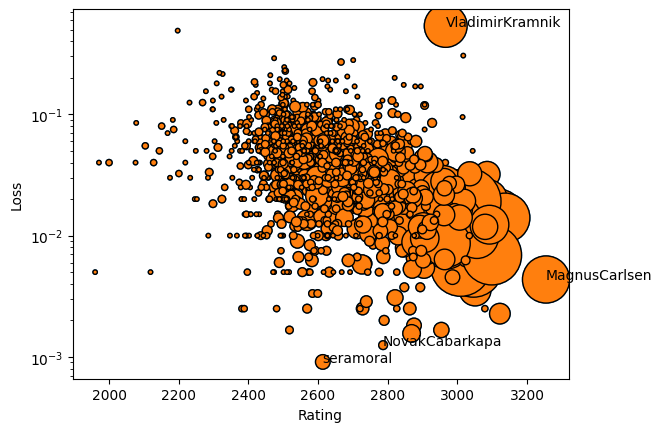

In [8]:
# Plot rating vs loss
import matplotlib.pyplot as plt
# size of each marker is proportional to the number of games played

plt.scatter(df["rating"], df["loss"], s= [10 * x for x in df["games"].to_list()])
# Black outline for each marker
plt.scatter(df["rating"], df["loss"], s= [10 * x for x in df["games"].to_list()], edgecolors="black")
# set y log
plt.yscale("log")
plt.ylabel("Loss")
plt.xlabel("Rating")

for i, txt in enumerate(df.index):
    if df["rating"][i] > 3200:
        plt.annotate(txt, (df["rating"][i], df["loss"][i]), fontsize=10)
    if df["loss"][i] > 0.5:
        plt.annotate(txt, (df["rating"][i], df["loss"][i]), fontsize=10)
    if df["loss"][i] < 0.0015 and df["rating"][i] < 2900:
        plt.annotate(txt, (df["rating"][i], df["loss"][i]), fontsize=10)

/var/folders/cp/m2q0dkfd3pq8z_955gmxfhv00000gn/T/ipykernel_33000/1917149831.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df["rating"][i] > 3200:
/var/folders/cp/m2q0dkfd3pq8z_955gmxfhv00000gn/T/ipykernel_33000/1917149831.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df["avg_rank"][i] < 2:
/var/folders/cp/m2q0dkfd3pq8z_955gmxfhv00000gn/T/ipykernel_33000/1917149831.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

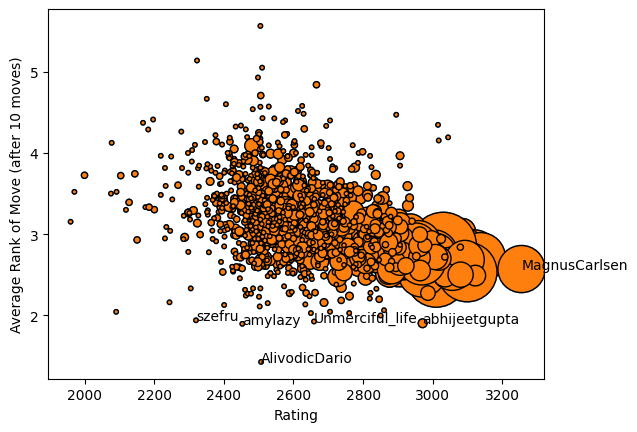

In [9]:
# Plot rating vs loss
import matplotlib.pyplot as plt
# size of each marker is proportional to the number of games played

plt.scatter(df["rating"], df["avg_rank"], s= [10 * x for x in df["games"].to_list()])
# Black outline for each marker
plt.scatter(df["rating"], df["avg_rank"], s= [10 * x for x in df["games"].to_list()], edgecolors="black")
plt.ylabel("Average Rank of Move (after 10 moves)")
plt.xlabel("Rating")


for i, txt in enumerate(df.index):
    if df["rating"][i] > 3200:
        plt.annotate(txt, (df["rating"][i], df["avg_rank"][i]), fontsize=10)
    if df["avg_rank"][i] < 2:
        plt.annotate(txt, (df["rating"][i], df["avg_rank"][i]), fontsize=10)

/var/folders/cp/m2q0dkfd3pq8z_955gmxfhv00000gn/T/ipykernel_33000/2086998393.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df.loc[df.games > 5,"rating"][i] > 3200:
/var/folders/cp/m2q0dkfd3pq8z_955gmxfhv00000gn/T/ipykernel_33000/2086998393.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df.loc[df.games > 5,"perc_best_move_after_10"][i] > 0.8:
/var/folders/cp/m2q0dkfd3pq8z_955gmxfhv00000gn/T/ipykernel_33000/2086998393.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior)

(0.3, 0.6)

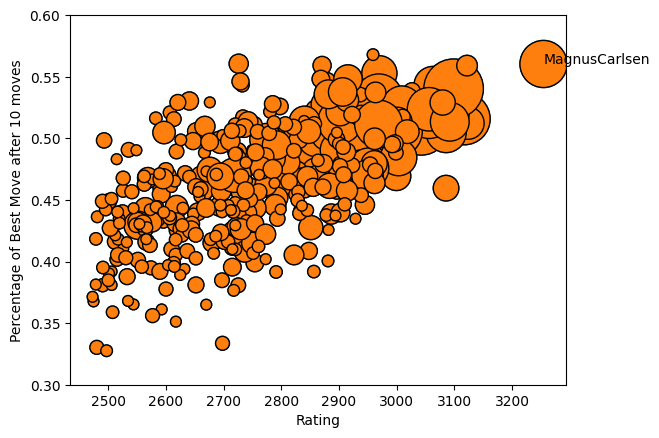

In [10]:
# Plot rating vs loss
import matplotlib.pyplot as plt
# size of each marker is proportional to the number of games played

plt.scatter(df.loc[df.games > 5, "rating"], df.loc[df.games > 5,"perc_best_move_after_10"], s= [10 * x for x in df.loc[df.games > 5,"games"].to_list()])
# Black outline for each marker
plt.scatter(df.loc[df.games > 5,"rating"], df.loc[df.games > 5,"perc_best_move_after_10"], s= [10 * x for x in df.loc[df.games > 5,"games"].to_list()], edgecolors="black")
plt.ylabel("Percentage of Best Move after 10 moves")
plt.xlabel("Rating")

for i, txt in enumerate(df.loc[df.games > 5].index):
    if df.loc[df.games > 5,"rating"][i] > 3200:
        plt.annotate(txt, (df.loc[df.games > 5,"rating"][i], df.loc[df.games > 5,"perc_best_move_after_10"][i]), fontsize=10)
    if df.loc[df.games > 5,"perc_best_move_after_10"][i] > 0.8:
        plt.annotate(txt, (df.loc[df.games > 5,"rating"][i], df.loc[df.games > 5,"perc_best_move_after_10"][i]), fontsize=10)

plt.ylim(0.3,0.6)

/var/folders/cp/m2q0dkfd3pq8z_955gmxfhv00000gn/T/ipykernel_33000/1141148554.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df.loc[df.games > 5,"rating"][i] > 3200:
/var/folders/cp/m2q0dkfd3pq8z_955gmxfhv00000gn/T/ipykernel_33000/1141148554.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (df.loc[df.games > 5,"rating"][i], df.loc[df.games > 5,"very_good_move"][i]), fontsize=10)


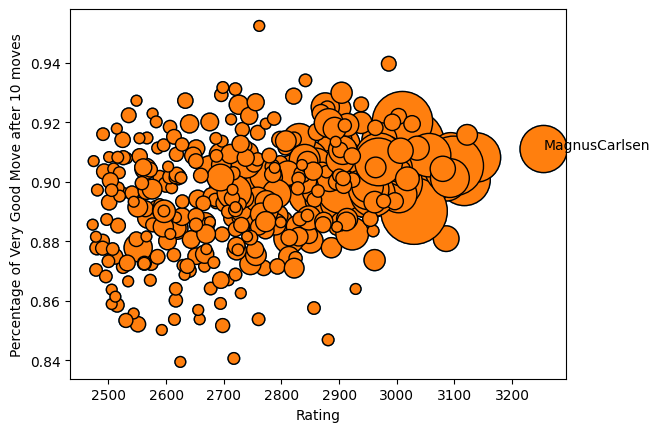

In [11]:

plt.scatter(df.loc[df.games > 5,"rating"], df.loc[df.games > 5,"very_good_move"], s= [10 * x for x in df.loc[df.games > 5,"games"].to_list()])
# Black outline for each marker
plt.scatter(df.loc[df.games > 5,"rating"], df.loc[df.games > 5,"very_good_move"], s= [10 * x for x in df.loc[df.games > 5,"games"].to_list()], edgecolors="black")
plt.ylabel("Percentage of Very Good Move after 10 moves")
plt.xlabel("Rating")
# For players with rating > 3000 add name
for i, txt in enumerate(df.loc[df.games > 5].index):
    if df.loc[df.games > 5,"rating"][i] > 3200:
        plt.annotate(txt, (df.loc[df.games > 5,"rating"][i], df.loc[df.games > 5,"very_good_move"][i]), fontsize=10)